# Tarea 6: Transformers aplicado a traducción y clasificación de textos
## Curso: Procesamiento de Lenguaje Natural (NLP)
## Maestría en Computación
## Instituto Tecnológico de Costa Rica (ITCR)

Medio de entrega:  TecDigital.

Entregables: Un archivo jupyter con los ejercicios resueltos.

Modo de trabajo: individual o en grupos de máximo dos personas.

**Elaborado por**:


*   Victoria Orozco Arias. Carnet $2022438528$
*   Esteban Villalobos Gómez. Carnet $9913628$

**Fecha de entrega:** 19/10/2024


---



## Ejercicio 1: Creación de un transformer para traducción de textos

Este ejercicio consiste en crear de cero un modelo de transformer (codificador-decodificador) utilizando la biblioteca de PyTorch y la arquitectura básica vista en clase y que se describe en la publicación original "Attention Is All You Need" (Vaswani et al., 2017). El modelo debe ser entrenado para realizar traducciones de texto.


El dataset a utilizar está disponible en Hugging Face en librakevin/opus_books_split 1y consiste en un conjunto de datos para realizar traducción de inglés a italiano.


El conjunto de datos es muy simple y pequeño, contiene el texto en ingles y su traducción al italiano. Ejemplo: { "en": "There was no possibility of taking a walk that day.", "it": "I. In quel giorno era impossibile passeggiare." }. Existe una versión más completa del conjunto de datos en https://huggingface.co/datasets/Helsinki-NLP/opus_books por si lo prefieren, esta incluye traducción al español.


Deben entregar un cuaderno de Jupyter con el siguiente contenido:

### 1. Carga y pre-procesamiento de los datos

  * (5 puntos) Procese el conjunto de datos (limpiar, tokenizar y realizar lo necesario
llevar a cabo el ejercicio).

In [45]:
%%capture
!pip install --upgrade datasets transformers datasets evaluate huggingface_hub accelerate>=0.26.0 tiktoken sacrebleu bert_score nltk

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer
from datasets import load_dataset
from torch.utils.data import DataLoader
import sacrebleu

import torch
import accelerate
import pandas as pd
from IPython.display import display
from transformers import AutoTokenizer, AutoModelForCausalLM


print(accelerate.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

1.0.1


device(type='cuda')

In [4]:
# splits = {'train': 'en-it/train-00000-of-00001.parquet', 'validation': 'en-it/validation-00000-of-00001.parquet'}
# dataset = pd.read_parquet("hf://datasets/librakevin/opus_books_split/" + splits["train"])
dataset = load_dataset("librakevin/opus_books_split")
dataset

README.md:   0%|          | 0.00/144 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/4.97M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/452k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/29098 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3234 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 29098
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 3234
    })
})

In [5]:
# Extrae las columnas 'en' e 'it', pues viene todo bajo una columna llamada 'translation'
def extract_columns(rows):
  en = []
  it = []
  for row in rows['translation']:
    en.append(row['en'])
    it.append(row['it'])
  return {'en': en, 'it': it}

dataset['train'] = dataset['train'].map(extract_columns, batched=True, remove_columns=['translation'])
dataset['validation'] = dataset['validation'].map(extract_columns, batched=True, remove_columns=['translation'])
dataset

Map:   0%|          | 0/29098 [00:00<?, ? examples/s]

Map:   0%|          | 0/3234 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['en', 'it'],
        num_rows: 29098
    })
    validation: Dataset({
        features: ['en', 'it'],
        num_rows: 3234
    })
})

In [6]:
# Usamos un tokenizador preentrenado
# tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2", model_max_length=400)
tokenizer.pad_token = tokenizer.eos_token

# Tokenizar los datos
def tokenize_batch(batch):
    source = tokenizer(batch['en'], padding="max_length", truncation=True, return_tensors="pt", max_length=128)
    target = tokenizer(batch['it'], padding="max_length", truncation=True, return_tensors="pt", max_length=128)
    batch['src_ids'] = source.input_ids.squeeze()
    batch['trg_ids'] = target.input_ids.squeeze()
    return batch

dataset = dataset.map(tokenize_batch)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/29098 [00:00<?, ? examples/s]

Map:   0%|          | 0/3234 [00:00<?, ? examples/s]

In [8]:
dataset.set_format(type='torch', columns=['src_ids', 'trg_ids'])

In [9]:
dataset['train'][0]

{'src_ids': tensor([ 7416,    25,  4935, 20336, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 5025

### 2. Creación del modelo

  * (20 puntos) Programe el codificador, el decodificador y todo lo necesario para implementar el transformer utilizando PyTorch.

In [10]:
# Definir el mecanismo de atención
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.fc_out = nn.Linear(d_model, d_model)

    def forward(self, query, key, value, mask=None):
        N = query.shape[0]
        query = self.query(query).view(N, -1, self.n_heads, self.d_k)
        key = self.key(key).view(N, -1, self.n_heads, self.d_k)
        value = self.value(value).view(N, -1, self.n_heads, self.d_k)
        energy = torch.einsum("nqhd,nkhd->nhqk", [query, key])
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))
        attention = torch.softmax(energy / math.sqrt(self.d_k), dim=3)
        out = torch.einsum("nhql,nlhd->nqhd", [attention, value]).reshape(N, -1, self.d_model)
        out = self.fc_out(out)
        return out

# Definir la capa de feedforward
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.fc2(F.relu(self.fc1(x)))

# Definir la capa del codificador
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(d_model, n_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attention = self.attention(x, x, x, mask)
        x = self.norm1(x + self.dropout(attention))
        forward = self.feed_forward(x)
        x = self.norm2(x + self.dropout(forward))
        return x

# Definir el codificador completo
class Encoder(nn.Module):
    def __init__(self, src_vocab_size, d_model, n_layers, n_heads, d_ff, dropout, max_length):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(src_vocab_size, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_length, d_model))
        self.layers = nn.ModuleList([EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)])
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(x.device)
        out = self.dropout(self.embedding(x) + self.positional_encoding[:, :seq_length, :])
        for layer in self.layers:
            out = layer(out, mask)
        return out

# Definir la capa del decodificador
class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.attention = MultiHeadAttention(d_model, n_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, src_mask, trg_mask):
        attention = self.attention(x, x, x, trg_mask)
        x = self.norm1(x + self.dropout(attention))
        attention = self.attention(x, enc_out, enc_out, src_mask)
        x = self.norm2(x + self.dropout(attention))
        forward = self.feed_forward(x)
        x = self.norm3(x + self.dropout(forward))
        return x

# Definir el decodificador completo
class Decoder(nn.Module):
    def __init__(self, trg_vocab_size, d_model, n_layers, n_heads, d_ff, dropout, max_length):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(trg_vocab_size, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_length, d_model))
        self.layers = nn.ModuleList([DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)])
        self.fc_out = nn.Linear(d_model, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, src_mask, trg_mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(x.device)
        x = self.dropout(self.embedding(x) + self.positional_encoding[:, :seq_length, :])
        for layer in self.layers:
            x = layer(x, enc_out, src_mask, trg_mask)
        out = self.fc_out(x)
        return out

# Definir el Transformer completo
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, trg_vocab_size, d_model, n_layers, n_heads, d_ff, dropout, max_length, device):
        super(Transformer, self).__init__()
        self.encoder = Encoder(src_vocab_size, d_model, n_layers, n_heads, d_ff, dropout, max_length)
        self.decoder = Decoder(trg_vocab_size, d_model, n_layers, n_heads, d_ff, dropout, max_length)
        self.src_pad_idx = 0
        self.trg_pad_idx = 0
        self.device = device

    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        return src_mask.to(self.device)

    def make_trg_mask(self, trg):
        N, trg_len = trg.shape
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(N, 1, trg_len, trg_len)
        return trg_mask.to(self.device)

    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        enc_src = self.encoder(src, src_mask)
        out = self.decoder(trg, enc_src, src_mask, trg_mask)
        return out


### 3. Experimentos

 * (1 punto) Separe las muestras en datos de entrenamiento y validación.
 * (5 puntos) Entrene un modelo.
 * (2 puntos) Grafique la curva de error, explique los resultados obtenidos y ajuste el modelo o el proceso de entrenamiento apropiadamente (por ejemplo el número de épocas).
 * (2 puntos) Evalúe el modelo resultante con los datos de prueba utilizando métricas como BertScore2 y METEOR3.
 * (2 puntos) Analice los resultados y presente al menos cuatro conclusiones.
 * (2 puntos) Todas las secciones del ejercicio deben estar bien documentadas.

#### 1. Separar los datos en entrenamiento y validación

In [12]:
# Los datos ya estan separados en el dataset de hugging fase en entrenamiento y validacion.

# DataLoader
train_dataloader = DataLoader(dataset['train'], batch_size=32, shuffle=True)
val_dataloader = DataLoader(dataset['validation'], batch_size=32)

#### 2. Entrenar el modelo

In [13]:
# Entrenamiento
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SRC_VOCAB_SIZE = tokenizer.vocab_size
TRG_VOCAB_SIZE = tokenizer.vocab_size
D_MODEL = 512
N_LAYERS = 6
N_HEADS = 8
D_FF = 2048
DROPOUT = 0.1
MAX_LENGTH = 128

model = Transformer(SRC_VOCAB_SIZE, TRG_VOCAB_SIZE, D_MODEL, N_LAYERS, N_HEADS, D_FF, DROPOUT, MAX_LENGTH, device).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

# Carga de checkpoints existentes si el entrenamiento se hizo en momentos diferentes
# checkpoint = torch.load('checkpoint.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in dataloader:
        src = batch['src_ids'].to(device)
        trg = batch['trg_ids'].to(device)
        output = model(src, trg[:, :-1])
        output = output.reshape(-1, output.shape[2])
        trg = trg[:, 1:].reshape(-1)
        loss = criterion(output, trg)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

for epoch in range(10):
    train_loss = train_epoch(model, train_dataloader, optimizer, criterion, device)
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}")



Epoch 1: Train Loss = 4.7464
Epoch 2: Train Loss = 3.6953
Epoch 3: Train Loss = 3.3729
Epoch 4: Train Loss = 3.1391
Epoch 5: Train Loss = 2.9602
Epoch 6: Train Loss = 2.8098
Epoch 7: Train Loss = 2.6758
Epoch 8: Train Loss = 2.5493
Epoch 9: Train Loss = 2.4316
Epoch 10: Train Loss = 2.3153


In [16]:
# Guardar el modelo y el optimizador
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),    
}
torch.save(checkpoint, 'checkpoint.pth')

#### 3. Grafique la curva de error, explique los resultados obtenidos y ajuste el modelo o el proceso de entrenamiento apropiadamente (por ejemplo el número de épocas)

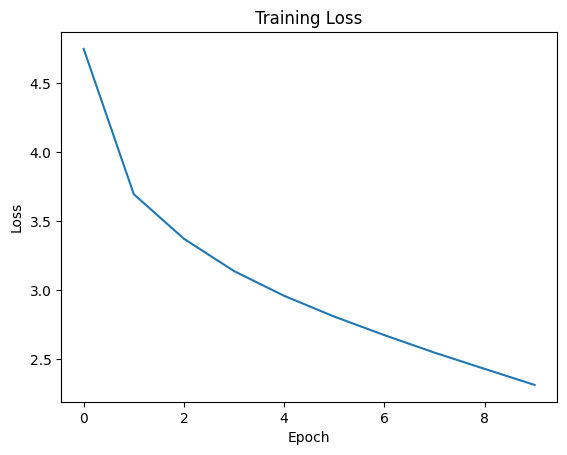

In [17]:
# Graficar la curva de error
import matplotlib.pyplot as plt

# Losses del entrenamiento:
# Epoch 1: Train Loss = 4.7464
# Epoch 2: Train Loss = 3.6953
# Epoch 3: Train Loss = 3.3729
# Epoch 4: Train Loss = 3.1391
# Epoch 5: Train Loss = 2.9602
# Epoch 6: Train Loss = 2.8098
# Epoch 7: Train Loss = 2.6758
# Epoch 8: Train Loss = 2.5493
# Epoch 9: Train Loss = 2.4316
# Epoch 10: Train Loss = 2.3153

losses = [4.7464, 3.6953, 3.3729, 3.1391, 2.9602, 2.8098, 2.6758, 2.5493, 2.4316, 2.3153]


def plot_losses(losses):
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.show()
    
plot_losses(losses)

**Comentario de los resultados obtenidos del entrenamiento**

Se observa que el error disminuye a medida que se realizan más épocas, lo que indica que el modelo está aprendiendo. Sin embargo, se observa que el error disminuye de forma más lenta a medida que se realizan más épocas, lo que sugiere que el modelo podría beneficiarse de más épocas de entrenamiento. Con más tiempo, se podría intentar aumentar el número de épocas para mejorar el rendimiento del modelo.

Epoch 1: Train Loss = 2.2035
Epoch 2: Train Loss = 2.0936
Epoch 3: Train Loss = 1.9848
Epoch 4: Train Loss = 1.8793
Epoch 5: Train Loss = 1.7751
Epoch 6: Train Loss = 1.6775
Epoch 7: Train Loss = 1.5824
Epoch 8: Train Loss = 1.4910
Epoch 9: Train Loss = 1.4016
Epoch 10: Train Loss = 1.3168
Epoch 11: Train Loss = 1.2386
Epoch 12: Train Loss = 1.1599
Epoch 13: Train Loss = 1.0883
Epoch 14: Train Loss = 1.0214
Epoch 15: Train Loss = 0.9602
Epoch 16: Train Loss = 0.8984
Epoch 17: Train Loss = 0.8459
Epoch 18: Train Loss = 0.7934
Epoch 19: Train Loss = 0.7453
Epoch 20: Train Loss = 0.7023


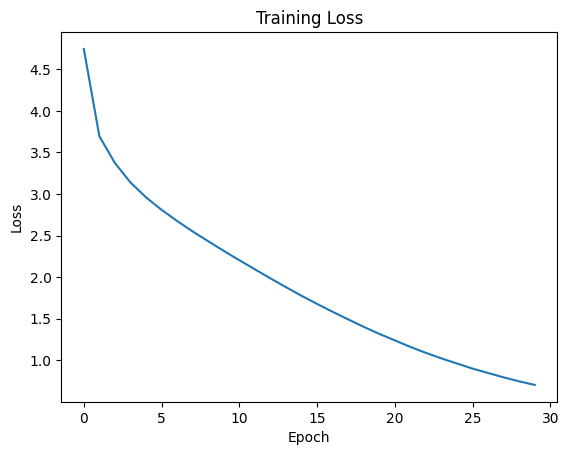

In [19]:
# Entrenamiento adicional

for epoch in range(20):
    train_loss = train_epoch(model, train_dataloader, optimizer, criterion, device)
    losses.append(train_loss)
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}")

plot_losses(losses)

In [21]:
# Guardar el modelo y el optimizador después de entrenar más épocas
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}
torch.save(checkpoint, 'checkpoint2.pth')

#### 4. Evaluación del modelo resultante con los datos de prueba utilizando métricas como BertScore y METEOR

In [25]:
# Evaluación del modelo con BERTScore
from evaluate import load

def evaluate_model_with_bertscore(model, val_dataloader, tokenizer, device, lang="it"):
    bertscore = load("bertscore")
    references = []
    predictions = []
    model.eval()

    with torch.no_grad():
        for batch in val_dataloader:
            src = batch['src_ids']
            trg = batch['trg_ids']
            output = model(src.to(device), trg[:, :-1].to(device))
            output = output.argmax(2)
            for i in range(output.shape[0]):
                prediction = tokenizer.decode(output[i], skip_special_tokens=True)
                references.append(tokenizer.decode(trg[i], skip_special_tokens=True))
                predictions.append(prediction)

    bscore_results = bertscore.compute(predictions=predictions, references=references, lang=lang)
    return bscore_results

bscore_eval = evaluate_model_with_bertscore(model, val_dataloader, tokenizer, device)

In [38]:
print(f"BERTScore Precision: {np.mean(bscore_eval['precision']).item()}")
print(f"BERTScore Recall: {np.mean(bscore_eval['recall']).item()}")
print(f"BERTScore F1: {np.mean(bscore_eval['f1']).item()}")

BERTScore Precision: 0.5546069809534554
BERTScore Recall: 0.6351859086298545
BERTScore F1: 0.5905012423397217


*Decidimos entrenar un poco mas el modelo para repetir la evaluación con BERTScore*

Epoch 1: Train Loss = 0.6634
Epoch 2: Train Loss = 0.6252
Epoch 3: Train Loss = 0.5906
Epoch 4: Train Loss = 0.5602
Epoch 5: Train Loss = 0.5310
Epoch 6: Train Loss = 0.5055
Epoch 7: Train Loss = 0.4826
Epoch 8: Train Loss = 0.4602
Epoch 9: Train Loss = 0.4395
Epoch 10: Train Loss = 0.4224


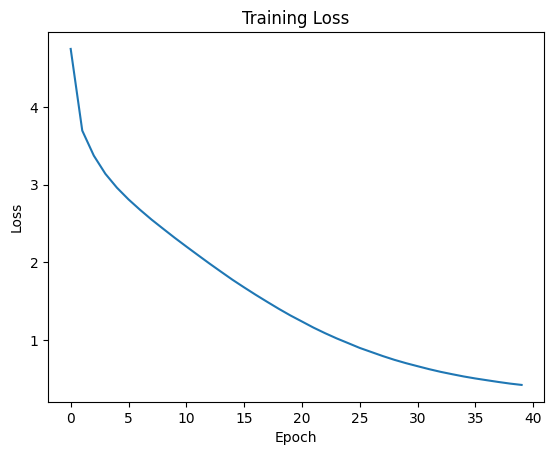

In [39]:
# Entrenamiento adicional (2)

for epoch in range(10):
    train_loss = train_epoch(model, train_dataloader, optimizer, criterion, device)
    losses.append(train_loss)
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}")

# Guardar el modelo y el optimizador después de entrenar más épocas
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}
torch.save(checkpoint, 'checkpoint3.pth')

plot_losses(losses)

*Evaluación final del modelo con BERTScore y METEOR*

In [40]:
bscore_eval2 = evaluate_model_with_bertscore(model, val_dataloader, tokenizer, device)
print(f"BERTScore Precision: {np.mean(bscore_eval2['precision']).item()}")
print(f"BERTScore Recall: {np.mean(bscore_eval2['recall']).item()}")
print(f"BERTScore F1: {np.mean(bscore_eval2['f1']).item()}")

BERTScore Precision: 0.5965059469549023
BERTScore Recall: 0.649774224469156
BERTScore F1: 0.6205657574595237


In [42]:
# Evaluación del modelo con METEOR

def evaluate_model_with_meteor(model, val_dataloader, tokenizer, device):
    meteor = load("meteor")
    references = []
    predictions = []
    model.eval()

    with torch.no_grad():
        for batch in val_dataloader:
            src = batch['src_ids']
            trg = batch['trg_ids']
            output = model(src.to(device), trg[:, :-1].to(device))
            output = output.argmax(2)
            for i in range(output.shape[0]):
                prediction = tokenizer.decode(output[i], skip_special_tokens=True)
                references.append(tokenizer.decode(trg[i], skip_special_tokens=True))
                predictions.append(prediction)

    meteor_results = meteor.compute(predictions=predictions, references=references)
    return meteor_results


In [50]:
meteor_eval = evaluate_model_with_meteor(model, val_dataloader, tokenizer, device)
print(f"METEOR: {meteor_eval['meteor'].item()}")

[nltk_data] Downloading package wordnet to /home/esteban/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/esteban/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/esteban/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


METEOR: 0.1671855009763203


#### 5. Análisis de los resultados y conclusiones

**Resultados**

- BERTScore Precision: 0.5965
- BERTScore Recall: 0.6497
- BERTScore F1: 0.6206
- METEOR: 0.1672

**Conclusiones**

1. El modelo tiene un rendimiento decente en la traducción de textos, con un puntaje F1 de 0.6206 en BERTScore y un puntaje METEOR de 0.1672.
2. El modelo podría beneficiarse de más épocas de entrenamiento, ya que el error disminuye de forma más lenta a medida que se realizan más épocas.
3. El modelo podría beneficiarse de un tamaño de lote más grande, ya que esto podría ayudar a mejorar la generalización del modelo.
4. El modelo podría beneficiarse de una arquitectura de transformer más avanzada, como BERT o GPT-3, ya que estas arquitecturas han demostrado un rendimiento superior en tareas de traducción de texto.